## Introduction to Image Processing with Python
### Image Processing (RM1-VIS)
### University of Southern Denmark

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage


In [2]:
def plotImage(image, title):
    if(len(image.shape) == 2):
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Least-Squares Filtering



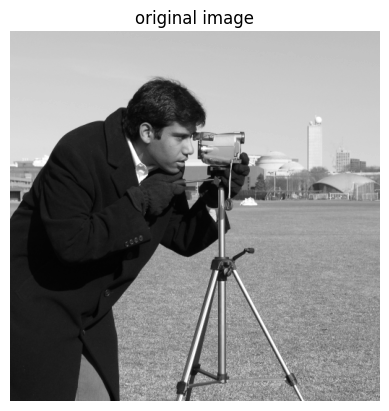

In [3]:
image = skimage.data.camera()
plotImage(image, "original image")

In [4]:
# returns the degradation transfer function in centered frequence domain
def H(shape):
    
    H = np.zeros(shape, dtype="complex128")

    T = 1.0
    a = 0.1
    b = 0.1

    for i in range(0, H.shape[0]):
        for j in range(0, H.shape[1]):
            u = i-(H.shape[0]/2)
            v = j-(H.shape[1]/2)
            k = np.pi * (u*a + v*b)
            if (k == 0):
                H[i, j] = 1
            else:
                H[i, j] = T/k * np.sin(k) * np.exp(-1j * k)

    return H

Apply the degradation transfer function H and Gaussian noise with a mean value of 10px and std. dev. of 10px.

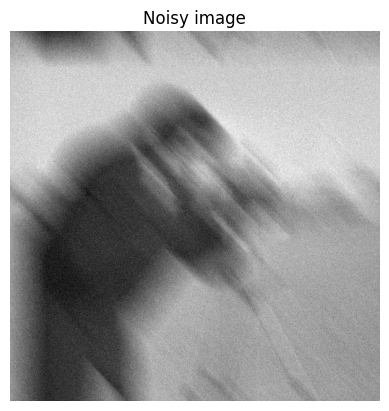

In [5]:
def apply_degradation_function(img, H):
    #transforming image into frequency domain using real values from the image (result is non-redundant part of FFT)
    f_transform = np.fft.rfft2(img)
    #shift zero-freq to the center of the spectrum
    f_transform_shifted = np.fft.fftshift(f_transform)
    #apply the degradation function
    degraded_freq = f_transform_shifted * H(f_transform.shape)
    #first shift back to original position and then transform the image back to spacial domain
    degraded_img=np.fft.irfft2(np.fft.ifftshift(degraded_freq))
    return degraded_img

def create_noisy_image(img):
    #given values
    mean =10
    std_dev=10
    #generate Gaussian noise with the given mean and standard deviation (the result is an array the shape of the image)
    noise = np.random.normal(mean, std_dev, img.shape)
    #add noise to the picture
    noisy_img = img+noise
    return noisy_img

noisyImage = create_noisy_image(apply_degradation_function(image, H))
plotImage(noisyImage, "Noisy image")

Implement LSF as detailed in GW 4th ed., Sec 5.9.

gamma= 0.01
r_sq= 23730367.29371986
eta_sq= 26316800
gamma= 0.011
r_sq= 23813950.480962902
eta_sq= 26316800
gamma= 0.012
r_sq= 23888323.783602804
eta_sq= 26316800
gamma= 0.013000000000000001
r_sq= 23955196.10072977
eta_sq= 26316800
gamma= 0.014000000000000002
r_sq= 24015856.49083011
eta_sq= 26316800
gamma= 0.015000000000000003
r_sq= 24071298.61998643
eta_sq= 26316800
gamma= 0.016000000000000004
r_sq= 24122302.819634005
eta_sq= 26316800
gamma= 0.017000000000000005
r_sq= 24169491.848776236
eta_sq= 26316800
gamma= 0.018000000000000006
r_sq= 24213369.784881413
eta_sq= 26316800
gamma= 0.019000000000000006
r_sq= 24254349.76957831
eta_sq= 26316800
gamma= 0.020000000000000007
r_sq= 24292774.20167048
eta_sq= 26316800
gamma= 0.021000000000000008
r_sq= 24328929.695587795
eta_sq= 26316800
gamma= 0.02200000000000001
r_sq= 24363058.338662636
eta_sq= 26316800
gamma= 0.02300000000000001
r_sq= 24395366.284203287
eta_sq= 26316800
gamma= 0.02400000000000001
r_sq= 24426030.395666063
eta_sq= 26316800
gamma

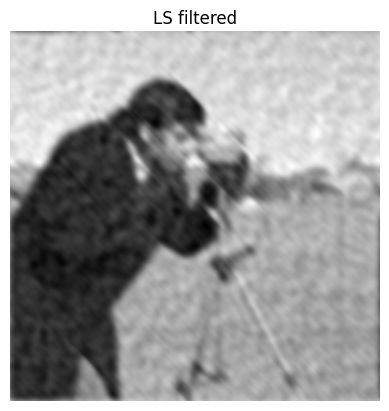

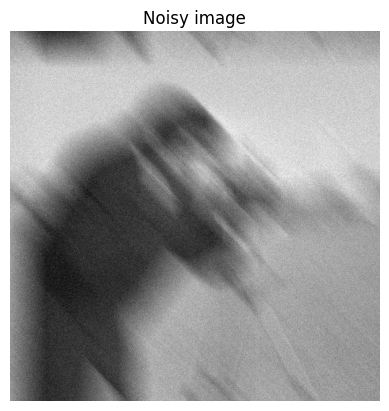

In [6]:
def least_squares_filtered(degraded_img,H,alpha):
    #given values
    mean=10
    std_dev=10
    #initial values
    delta_gamma=0
    gamma=0.01
    #transform the img to frequency domain and shift it
    G=np.fft.fftshift(np.fft.rfft2(degraded_img))
    #generate the degradation function and get variables for the equation 5-89
    H=H(G.shape)
    H_star=np.conj(H)
    H_squared=np.abs(H)**2
    #laplacian kernel 5-90
    laplacian=np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=float)
    #transform the laplacian to frequency domain, s=degraded_image shape ensures zero-padding the kernel so the result is the size of the img, then shift it
    P=np.fft.fftshift(np.fft.rfft2(laplacian,s=degraded_img.shape))
    #variable for equation 5-89
    P_squared=np.abs(P)**2
    for i in range(1000):
        #change gamma after each iteration
        gamma+=delta_gamma
        #equation 5-89
        F_hat=(H_star*G)/(H_squared+gamma*P_squared)
        #shift back and convert to the spacial domain to get the restored img
        img_restored=np.fft.irfft2(np.fft.ifftshift(F_hat))
        #calculate residual error equation 5-94
        residual=G-H*F_hat
        #obttain r(x,y) by using inverse fft
        r=np.fft.irfft2(np.fft.ifftshift(residual))
        #calculate r norm squared equation 5-95
        r_squared=np.sum(r**2)
        #calculate eta norm squared using the given values and equation 5-98
        eta_squared=G.shape[0]*G.shape[1]*(std_dev**2+mean**2)
        #print values for each iteration
        print("gamma=",gamma)
        print("r_sq=",r_squared)
        print("eta_sq=",eta_squared)
        #convergence is achieved when the modified equation 5-93 is satisfied with the given accuracy factor
        if np.abs(r_squared-eta_squared)<=alpha:
            print("Achieved convergence")
            #found the best gamma for the given image
            break
        elif r_squared<(eta_squared-alpha):
            #increase gamma
            delta_gamma=0.001
            i+=1
        elif r_squared>(eta_squared+alpha):
            #decrease gamma
            delta_gamma=-0.001
            i+=1
    #return the image filtered with the best gamma
    return img_restored
noisyImage = create_noisy_image(apply_degradation_function(image, H))
restored_img=least_squares_filtered(noisyImage,H,10000)
plotImage(restored_img, "LS filtered")
plotImage(noisyImage, "Noisy image")


Optional: implement Newton-Raphson optimization to speed up convergence.